# Model Design & Method Selection

## ML Paradigm
**Paradigm:** Supervised Multiclass Classification.

**Objective:** Map sensor data to three specific states: **Baseline**,
**Stress**, **Recovery**.

**Justification:**
*   **Why Supervised?** We have reliable ground-truth labels (Wearable: "Stroop Task"; SWELL: "Time Pressure"). Unsupervised learning (clustering) would ignore these valuable labels.
*   **Why Multiclass?** Dataset highlights "Recovery" as a key physiological state. Binary classification (Stress vs. No Stress) would merge "Recovery" with "Baseline," failing to detect the lingering effects of stress.

## Input & Output Specification

**Input Track A: Feature-Based (Compatible with SWELL & Wearable)**
*   **Structure:** 1D Vector `[1, N_features]`.
*   **Content:** Domain-specific features extracted from raw signals.
    *   *HRV:* RMSSD, LF/HF Ratio (available in SWELL).
    *   *EDA:* Phasic/Tonic components (Wearable only).
*   **Constraint:** To perform cross-dataset validation, we must extract the exact HRV features from the Wearable dataset that exist in SWELL.

**Input Track B: Time-Series (Wearable Dataset ONLY)**
*   **Structure:** 3D Tensor `[Batch_Size, Window_Size, Channels]`.
*   **Preprocessing:** Raw signals (BVP @ 64Hz, EDA @ 4Hz) must be **resampled to 4Hz** and aligned.
*   **Windowing:** Sliding windows of 30–120 seconds with 50% overlap.

**Output Targets:**
*   `y = 0`: Baseline
*   `y = 1`: Stress
*   `y = 2`: Recovery

## Baseline Algorithms (Feature-Based)

**Selected Models:**
1.  **Random Forest (RF):** (Ensemble of 100+ trees)
2.  **Support Vector Machine (SVM):** (RBF Kernel)

**Why these methods?**
*   **Evidence:** The PDF cites prior work achieving ">99% accuracy" using just 8 discriminative features with these models.
*   **Small Data Robustness:** With only 36 (Wearable) and 25 (SWELL) subjects, deep networks risk overfitting. RF and SVM are mathematically more stable for small tabular datasets.
*   **Interpretability:** Random Forest provides "Feature Importance" scores, allowing us to prove which sensors (e.g., EDA vs. Heart Rate) actually drive the stress prediction.

## Advanced Algorithms (Time-Series)

**Selected Models:**
1.  **LSTM (Long Short-Term Memory):** 2-layer bidirectional architecture.
2.  **CNN-LSTM:** 1D-CNN for feature extraction fused with LSTM for temporal logic.

**Why these methods?**
*   **Temporal Dynamics:** Stress is not instant; it accumulates. LSTM captures the *trajectory* (e.g., "Heart rate is high AND not dropping" = Stress vs. "Heart rate is high BUT dropping fast" = Recovery).
*   **Raw Signal Power:** Unlike RF/SVM, these models learn directly from the raw signal shape, potentially capturing patterns (like specific EDA peak shapes) that manual features miss.
*   **Constraint:** These models will **only** be trained/tested on the Wearable dataset (SWELL lacks raw time-series data).

## Performance

**Metrics:**
*   **F1-Score (Macro):** The primary metric to handle class imbalance (users rest more than they stress).
*   **Confusion Matrix:** Essential to ensure "Recovery" is not misclassified as "Stress".

**Validation Protocol:**
1.  **LOSO (Leave-One-Subject-Out):** Train on N-1 subjects, Test on 1. This is mandatory to prove the model works on *new* users (generalization).
2.  **Cross-Dataset Check (RF/SVM Only):** Train Random Forest on Wearable-HRV features $\to$ Test on SWELL-HRV features. This validates if the "stress concept" holds true across different devices and contexts.

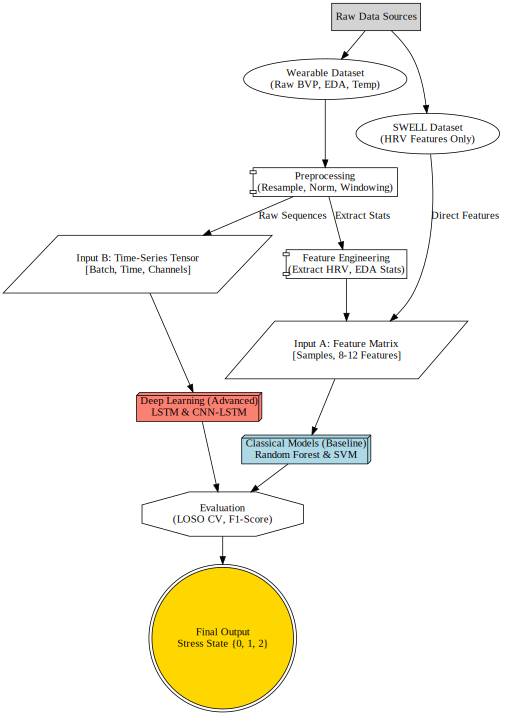

In [ ]:
# @title ML Pipeline Diagram
import graphviz

dot = graphviz.Digraph('ml_pipeline', comment='Phase 3 ML Pipeline')
dot.attr(rankdir='TB', size='10')

# Define Nodes
dot.node('A', 'Raw Data Sources', shape='box', style='filled', fillcolor='lightgrey')
dot.node('B', 'Wearable Dataset\n(Raw BVP, EDA, Temp)', shape='ellipse')
dot.node('C', 'SWELL Dataset\n(HRV Features Only)', shape='ellipse')

dot.node('D', 'Preprocessing\n(Resample, Norm, Windowing)', shape='component')
dot.node('E', 'Feature Engineering\n(Extract HRV, EDA Stats)', shape='component')

dot.node('F', 'Input A: Feature Matrix\n[Samples, 8-12 Features]', shape='parallelogram')
dot.node('G', 'Input B: Time-Series Tensor\n[Batch, Time, Channels]', shape='parallelogram')

dot.node('H', 'Classical Models (Baseline)\nRandom Forest & SVM', shape='box3d', style='filled', fillcolor='lightblue')
dot.node('I', 'Deep Learning (Advanced)\nLSTM & CNN-LSTM', shape='box3d', style='filled', fillcolor='salmon')

dot.node('J', 'Evaluation\n(LOSO CV, F1-Score)', shape='octagon')
dot.node('K', 'Final Output\nStress State {0, 1, 2}', shape='doublecircle', style='filled', fillcolor='gold')

# Define Edges
dot.edge('A', 'B')
dot.edge('A', 'C')

# Track 1: Feature Based (Uses BOTH datasets)
dot.edge('C', 'F', label='Direct Features')
dot.edge('B', 'D')
dot.edge('D', 'E', label='Extract Stats')
dot.edge('E', 'F')
dot.edge('F', 'H')

# Track 2: Deep Learning (Uses Wearable ONLY)
dot.edge('D', 'G', label='Raw Sequences')
dot.edge('G', 'I')

# Evaluation
dot.edge('H', 'J')
dot.edge('I', 'J')
dot.edge('J', 'K')

# Render
dot
